This notebook will be used to explore the dataset and determine cleaning and transformations needed before modeling. The final data cleaning script will be added to the source folder

In [122]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/cstone/Repositories/House-Price-Prediction_Multiple-Regression/data/raw/realtor-data.zip.csv')

df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [123]:
df.shape

(1401066, 10)

In [124]:
df.isna().sum()

status                 0
bed               216528
bath              194213
acre_lot          357467
city                 191
state                  0
zip_code             479
house_size        450112
prev_sold_date    686293
price                108
dtype: int64

In [125]:
df.loc[df['bath'].isnull()]

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
42,for_sale,NaN,NaN,0.99,Moca,Puerto Rico,676.0,43082.0,NaN,400000.0
43,for_sale,NaN,NaN,18.45,Hatillo,Puerto Rico,659.0,NaN,NaN,380000.0
59,for_sale,NaN,NaN,0.88,Aguada,Puerto Rico,602.0,NaN,NaN,35000.0
60,for_sale,NaN,NaN,0.21,Aguada,Puerto Rico,602.0,NaN,NaN,58000.0
61,for_sale,NaN,NaN,21.08,Aguada,Puerto Rico,602.0,NaN,NaN,85000.0
...,...,...,...,...,...,...,...,...,...,...
1401046,for_sale,NaN,NaN,35.60,Ny,New York,14062.0,1000.0,NaN,124900.0
1401051,for_sale,NaN,NaN,32.20,Forestville,New York,14062.0,NaN,NaN,164900.0
1401052,for_sale,NaN,NaN,33.00,Forestville,New York,14062.0,NaN,NaN,94900.0
1401053,for_sale,NaN,NaN,29.60,Forestville,New York,14062.0,NaN,NaN,99900.0


There's lots of missing values for house_size, bed and bath. Will some may be valid (i.e. studio apartments), it appears most are just incomplete. This is consistent with viewing homes on redfin. Sometimes this info is just missing from the listing. Given these will likely be the key factors in determining price, I'll go ahead and exclude the missing rows from the initial dataset

In [126]:
df2  = df.dropna(subset=['bed', 'bath', 'house_size'])

In [127]:

df2.isna().sum()

status                 0
bed                    0
bath                   0
acre_lot          230491
city                  88
state                  0
zip_code             115
house_size             0
prev_sold_date    419713
price                  0
dtype: int64

This still leaves us with half the original data (900k records). There's still a large missing amount of acre lot values. I would hypothesize that most of these are condo/apartments type properties. Since these records have all other information, I feel safe imputing the missing values with 0

In [128]:
df2['acre_lot'].fillna(0, inplace=True)

/var/folders/x_/nj1rjg193d57yw4b__nvy9j40000gn/T/ipykernel_74263/3081369541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['acre_lot'].fillna(0, inplace=True)


Next I'll look at some boxplots to examine any outliers

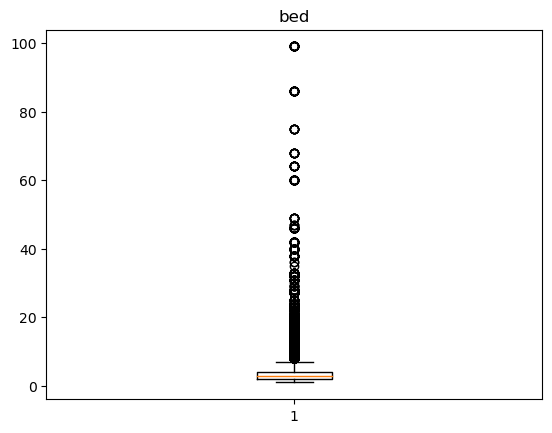

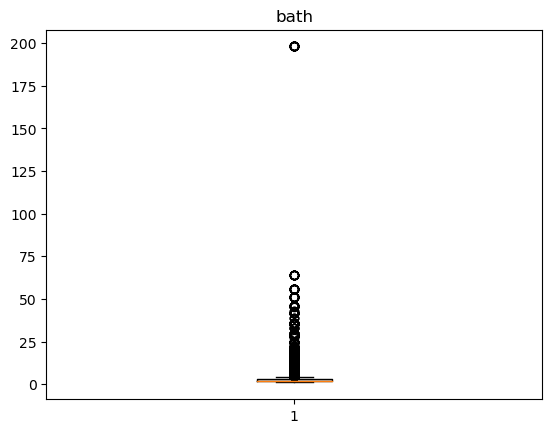

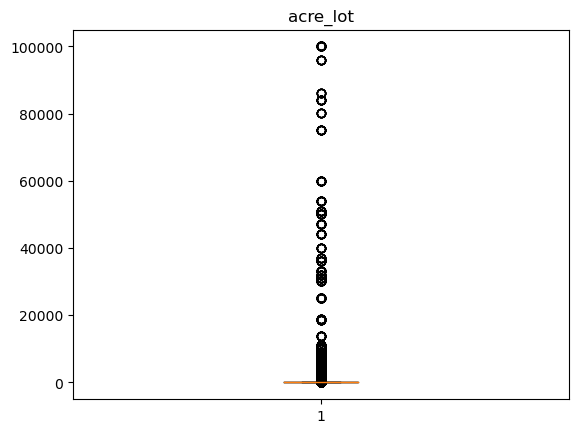

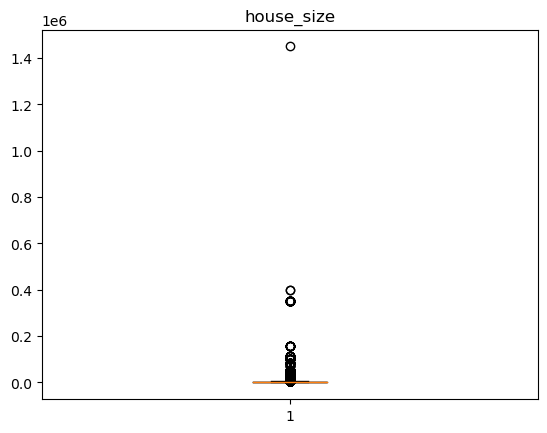

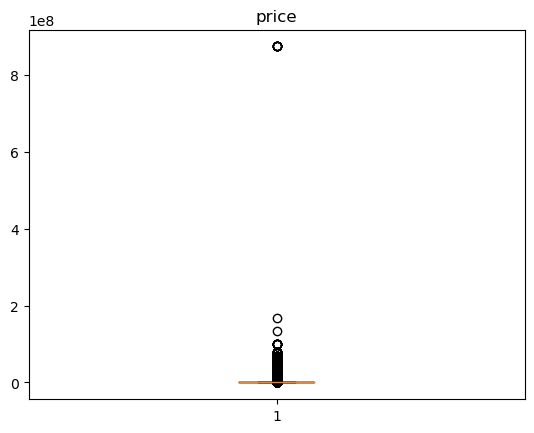

In [129]:
cols = ['bed', 'bath', 'acre_lot', 'house_size', 'price']

for i in cols:
    plt.figure()
    plt.boxplot(x=i, data=df2)
    plt.title(i)

#plt.boxplot(x='house_size', data=df2)

Most of these outliers will be important to keep as very large houses are still valid listings. However there's a few egregious outliers in price, bath, and house size that should be removed. 

In [163]:

outlier_cols = ['bed', 'bath', 'price', 'acre_lot', 'house_size']

Q1 = df2[outlier_cols].quantile(0.25)
Q3 = df2[outlier_cols].quantile(0.75)
IQR = Q3 - Q1

df3 = df2[~((df2[outlier_cols] < (Q1 - 1.5 * IQR)) |(df2[outlier_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [164]:
df3.shape

(671718, 10)

With so many missing values for last sold date, it may be best to convert these to a binary variable. Either the house has sold before or it hasnt

In [165]:

df3  = df3.dropna(subset=['city', 'zip_code'])
df3.isna().sum()

status                 0
bed                    0
bath                   0
acre_lot               0
city                   0
state                  0
zip_code               0
house_size             0
prev_sold_date    292786
price                  0
dtype: int64

In [166]:
df3['prev_sold'] = np.where(df3['prev_sold_date'] > '1800-01-01', 1, 0)


Using the avg price per zip code to account for varying real estate values in certain markets. 

In [167]:
zip_price = df3.groupby('zip_code')['price'].mean().reset_index()
df4 = df3.merge(zip_price, on='zip_code', how='inner')
df4 = df4.rename(columns={'price_y': 'zip_price'})


In [168]:
df4.sample(10)

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price_x,prev_sold,zip_price
59241,for_sale,3.0,2.0,0.21,Worcester,Massachusetts,1604.0,1388.0,NaN,209900.0,0,372992.528548
37464,for_sale,3.0,1.0,0.21,Adams,Massachusetts,1220.0,1632.0,2008-05-07,170000.0,1,193612.774451
326320,for_sale,1.0,1.0,0.00,Bronx,New York,10462.0,636.0,2016-07-18,210000.0,1,437318.402528
493394,for_sale,2.0,3.0,0.11,Langhorne,Pennsylvania,19047.0,1639.0,2001-09-05,450000.0,1,440413.636364
53945,for_sale,3.0,1.0,0.47,East Hartford,Connecticut,6118.0,1040.0,2019-02-11,195000.0,1,221354.539813
469244,for_sale,4.0,3.0,1.32,Dingmans Ferry,Pennsylvania,18328.0,3520.0,2021-03-09,415000.0,1,252778.217391
492193,for_sale,3.0,3.0,0.00,East Windsor,New Jersey,8520.0,1663.0,NaN,369000.0,0,384295.996528
508333,for_sale,3.0,1.0,0.02,Atlantic City,New Jersey,8401.0,1020.0,2016-08-22,99500.0,1,223261.356522
604328,for_sale,2.0,1.0,0.30,Kortright,New York,13750.0,1080.0,NaN,105000.0,0,105000.000000
495365,for_sale,4.0,3.0,0.81,Plainsboro,New Jersey,8512.0,2532.0,1992-06-18,589900.0,1,593925.668675


Dropping the columns no longer needed

In [169]:
df4 = df4.drop(['city', 'state', 'zip_code', 'prev_sold_date', 'status'], axis=1)

In [170]:
df4.sample(10)

,bed,bath,acre_lot,house_size,price_x,prev_sold,zip_price
460525,4.0,3.0,0.33,2375.0,749000.0,1,5.220051e+05
71474,3.0,3.0,0.33,1620.0,169000.0,0,1.912673e+05
305056,1.0,1.0,0.00,888.0,375000.0,0,4.247935e+05
396461,2.0,1.0,0.00,800.0,590000.0,0,5.770245e+05
573112,2.0,2.0,0.00,1434.0,319000.0,0,4.123889e+05
93833,5.0,2.0,0.15,1629.0,250000.0,0,3.251828e+05
48675,3.0,2.0,0.24,1004.0,229900.0,0,2.729632e+05
602448,6.0,2.0,0.05,3192.0,130000.0,1,1.493553e+05
479411,2.0,1.0,0.00,911.0,115000.0,0,3.361262e+05
149413,1.0,1.0,0.02,985.0,949000.0,0,1.067119e+06


Now that we have a clean dataset, this notebook will be used to build our data cleaning script. 